# `victor` usage demo

The purpose of this notebook is to demonstrate the usage of the **`victor`** code for analysis of the redshift-space cross-correlation function (CCF) between voids and galaxies or density-split-regions (DS) and galaxies. You need to have installed **`victor`** with:

`python -m pip install git+https://github.com/seshnadathur/victor.git@develop`

to run the examples given here.

In [1]:
# Start with basic module imports
import os
import numpy as np
import matplotlib.pyplot as plt
import yaml
from victor import CCFModel, plottools

%matplotlib inline
plt.style.use('seaborn-talk')

# 1. Using the `CCFModel` class for model calculations

## Setting up

Any model calculation requires first reading some input data from file, and specifying model choices. This demo uses model input data from the file `CMASS_zobovVoids_reconRs10_0.43z0.7_medianRvcut_PatchyMean_model.hdf5` in the folder `data/BOSS_DR12_CMASS/` under the top-level directory. This data comes from the BOSS void-galaxy CCF presented in [Nadathur *et al*. (2019)](https://arxiv.org/abs/1904.01030). The file path and the various default options we want to use here are specified in the YAML file `config/boss_config.yaml` under the `model` block, so the first step is to read these in: 

In [2]:
top_level_dir = os.path.dirname(os.getcwd()) # to step back up from the current notebook directory

with open(os.path.join(top_level_dir, 'config/boss_config.yaml')) as f:
    model = yaml.full_load(f)['model']

# see what model contains
model

{'input_model_data_file': 'data/BOSS_DR12_CMASS_data/CMASS_zobovVoids_reconRs10_0.43z0.7_medianRvcut_PatchyMean_model.hdf5',
 'rsd_model': 'streaming',
 'z_eff': 0.57,
 'cosmology': {'Omega_m': 0.31},
 'realspace_ccf': {'reconstruction': True,
  'beta_key': 'beta',
  'format': 'multipoles',
  'ccf_keys': ['r', 'monopole', 'quadrupole'],
  'assume_isotropic': True},
 'matter_ccf': {'model': 'template',
  'integrated': False,
  'template_keys': ['rdelta', 'delta'],
  'template_sigma8': 0.628,
  'bias': 1.9},
 'velocity_pdf': {'mean': {'model': 'linear',
   'empirical_corr': False,
   'template_keys': None},
  'dispersion': {'model': 'template', 'template_keys': ['rsv', 'sigmav']}}}

[Note that `model` in the cell above is simply a Python dictionary. Instead of reading it from a YAML file we could also have just provided the same information via a dictionary created in this notebook.]

For a fuller description of the different options that can be provided in `model` and what they refer to, have a look at the inline comments in the YAML file at `config/boss_config.yaml`.

## The input model data file

The most important information contained in `model` is the path to the input model data file (provided relative to the top level package directory). This file contains the input data necessary to compute the redshift-space void-galaxy or DS-galaxy CCF $\xi^s(\mathbf{s})$. The example data is arranged in HDF5 format, with arrays of different shapes identified by a series of keys. (The same information could also have been provided as a Python dictionary saved in `.npy` file format: `victor` can read either format so use whichever is more convenient and the code will deduce the format from the ending of the filename.) 

The input model data file **must** at a minimum contain information on the real-space CCF $\xi^r(\mathbf{r})$ since this is a necessary input to compute $\xi^s(\mathbf{s})$. The value of `model['realspace_ccf']['format']` above specifies that this realspace CCF information is provided in multipole format, and `model['realspace_ccf']['ccf_keys']` provide the keys to identify the arrays corresponding to values of $r$, the monopole moment $\xi^r_0(r)$, and the quadrupole moment $\xi^r_2(r)$in the file. [However, since `model['realspace_ccf']['assume_isotropic']` is set to `False`, the default settings will not actually use the quadrupole information.]

The input model data file **may** contain other optional information, depending on the use case. The most commonly used of these are:
* a template for the void-matter or DS-matter CCF $\delta(r)$ [necessary if `model['matter_ccf']['model']=='template'`, ignored otherwise]
    -  `model['matter_ccf']['template_keys']` provide the keys to identify the $r$ and $\delta(r)$ pairs in the file
    
    
* a template for the position-dependent standard deviation/RMS width $\sigma_v(r, \mu_r)$ of the (Gaussian) velocity PDF [always optional]
    - `model['velocity_pdf']['dispersion']['template_keys']` provide the keys to identify $r$, $\mu_r$ (optional, template can be spherically symmetric) and $\sigma_v(r, \mu_r)$ in the file
    
    
* **if** `model['realspace_ccf']['reconstruction']` is `True` as in this case, an array of the values of the reconstruction $\beta$ parameter used (identified by a key which should be specified in `model['realspace_ccf']['beta_key'])
    - if reconstruction has been used, the realspace CCF $\xi^r$ will also depend on $\beta$, so all multipoles provided will need to be 2D arrays with $\beta$ variation along the first dimension
    
Some additional things to note here:
1. If the void-matter or DS-matter template information in the file refers to the *enclosed* density contrast $\Delta(r)\equiv\frac{3}{r^3}\int_0^ry^2\delta(y)\,\mathrm{d}y$ rather than the matter CCF/density contrast in a shell $\delta(r)$, this can be specified by setting the value of `model['matter_ccf']['integrated']`.
2. If a matter template is used, information on the $\sigma_8$ value of the simulation used to calibrate this template **must** be provided, via the `template_sigma8` key. Note that this corresponds to $\sigma_8(z_\mathrm{sim})$ rather than at $\sigma_8(z=0)$! In the current case the template was calibrated using mocks in the Big MultiDark simulation at the redshift $z_\mathrm{sim}=0.52$.
3. The `bias` value here is somewhat arbitrary and is only ever used for some visualisation purposes, so don't worry too much about the exact value.

We can also double check the keys present in the input model data file and confirm that they match the values we have specified in `model`:

In [3]:
import h5py

with h5py.File(os.path.join(top_level_dir, 'data/BOSS_DR12_CMASS_data/CMASS_zobovVoids_reconRs10_0.43z0.7_medianRvcut_PatchyMean_model.hdf5'), 'r') as f:
    print(list(f.keys()))

['beta', 'delta', 'monopole', 'quadrupole', 'r', 'rdelta', 'rsv', 'sigmav']


We now use the `model` dictionary to initialize an instance of the `CCFModel` class. Note that file paths in the YAML file were provided relative to the top level package directory; since we are running in the `notebooks/` subfolder here we can simply add a `dir` key to the dictonary to correct for this.

In [4]:
model['dir'] = top_level_dir
ccf = CCFModel(model)

### Visualising the input data

Before starting any calculations, let's just check the input data we have provided:

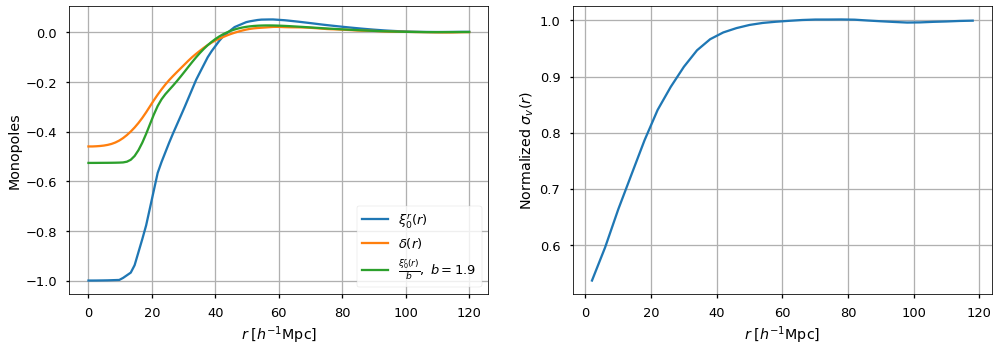

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# since the realspace ccf depends on beta, we must pass a value for beta in the call below
params = {'beta': 0.37}

r = np.linspace(0.01, 120, 100)
ccf.plot_realspace_multipoles({'beta': params['beta'], 'label': r'$\xi^r_0(r)$'}, r=r, ell=0, ax=ax1, **{'xlabel': r'$r\;[h^{-1}\mathrm{Mpc}]$', 'ylabel': r'Monopoles'})
# get the default template matter ccf profile
delta, integ_delta = ccf.delta_profiles(r, params)
# override the default set during initialisation through kwargs and calculate matter ccf using linear bias approximation
bias_delta, bias_integ_delta = ccf.delta_profiles(r, params, **{'matter_model': 'linear_bias'}) 

ax1.plot(r, delta, label=r'$\delta(r)$')
ax1.plot(r, bias_delta, label=rf'$\frac{{\xi^r_0(r)}}{{b}},\;b={model["matter_ccf"]["bias"]}$')
ax1.legend(loc='lower right')
ax1.grid()

from scipy.interpolate import RectBivariateSpline
# internally, victor always holds sigma_v(r, mu) even though in this example mu information is redundant 
sv_spl = RectBivariateSpline(ccf.r_for_sv, ccf.mu_for_sv, ccf.sv_rmu.T)
ax2.plot(ccf.r, sv_spl.ev(ccf.r, 0)) # choose any value 0<=mu<=1
ax2.grid()
ax2.set_xlabel(r'$r\;[h^{-1}\mathrm{Mpc}]$')
ax2.set_ylabel(r'Normalized $\sigma_v(r)$')
plt.tight_layout(w_pad=3)

The 'template' matter ccf profile $\delta(r)$ calibrated from voids in simulations is not quite the same as would be obtained from assuming a constant linear bias applied to the real-space CCF, $\xi^r_0/b$. Therefore the model results will also change depending on which one is used.

**Important note**: as the template profile of $\sigma_v(r, \mu_r)$ measured from simulations is usually quite noisy, the version used by `victor` and shown here by default has a small smoothing applied along the $r$ direction (using a [Savitzky-Golay](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html#scipy.signal.savgol_filter) filter with `window_length=3` and `polyorder=1`). This can be controlled by providing integer values for key options `filter_window` and `filter_order` under `model['velocity_pdf']['dispersion']` or turned off entirely by providing a key `filter` with value `False`.

## Computing models

The primary functionality of the `CCFModel` class is to allow computation of the multipoles of the redshift-space CCF at any given point in parameter space:

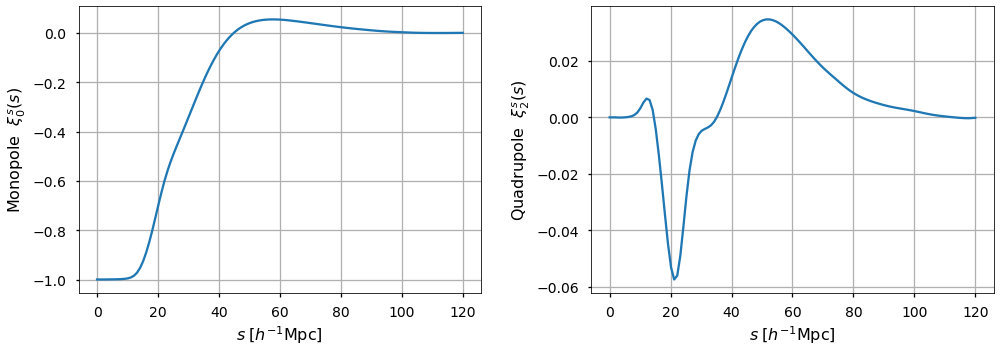

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# full set of parameters applicable for the template-based model used here is (fsigma8, beta, sigma_v, epsilon=aperp/apar)
params = {'fsigma8': 0.47, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 1.0}
s = np.linspace(0.01, 120, 120)
th = ccf.theory_multipoles(s, params, poles=[0, 2])
ax1.plot(s, th['0'])
ax2.plot(s, th['2'])
for ax in [ax1, ax2]: 
    ax.set_xlabel(r'$s\;[h^{-1}\mathrm{Mpc}]$', fontsize=16)
    ax.tick_params(labelsize=14)
    ax.grid()
ax1.set_ylabel(r'Monopole  $\xi^s_0(s)$', fontsize=16)
ax2.set_ylabel(r'Quadrupole  $\xi^s_2(s)$', fontsize=16)
plt.tight_layout(w_pad=3)

The default model evaluation options set during the initialization can also be overridden via kwargs provided in the function call (for a fuller discussion of the meanings of all the different model options see the separate notebook): 

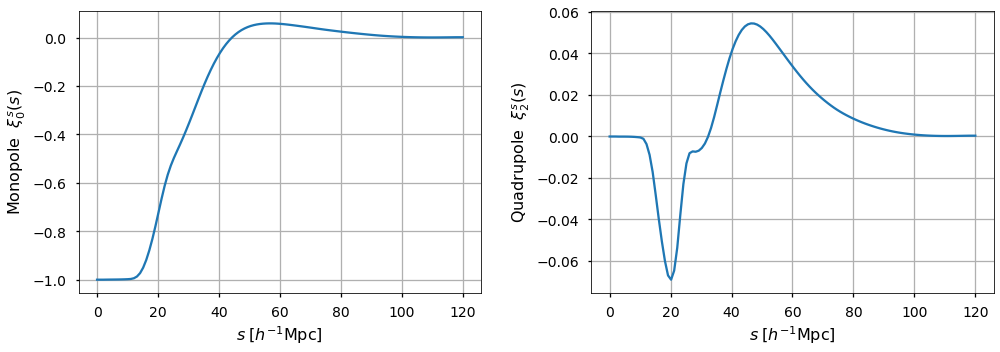

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# params can optionally provide aperp and apar individually instead of epsilon
params = {'fsigma8': 0.47, 'beta': 0.37, 'sigma_v': 380, 'aperp': 1.0, 'apar': 1.0}
s = np.linspace(0.01, 120, 120)
th = ccf.theory_multipoles(s, params, poles=[0, 2], **{'rsd_model': 'kaiser', 'matter_model': 'linear_bias'})
ax1.plot(s, th['0'])
ax2.plot(s, th['2'])
for ax in [ax1, ax2]: 
    ax.set_xlabel(r'$s\;[h^{-1}\mathrm{Mpc}]$', fontsize=16)
    ax.tick_params(labelsize=14)
    ax.grid()
ax1.set_ylabel(r'Monopole  $\xi^s_0(s)$', fontsize=16)
ax2.set_ylabel(r'Quadrupole  $\xi^s_2(s)$', fontsize=16)
plt.tight_layout(w_pad=3)

For plotting purposes it can be more convenient to use the `plot_model_multipoles` class method instead, especially when comparing different points in parameter space:

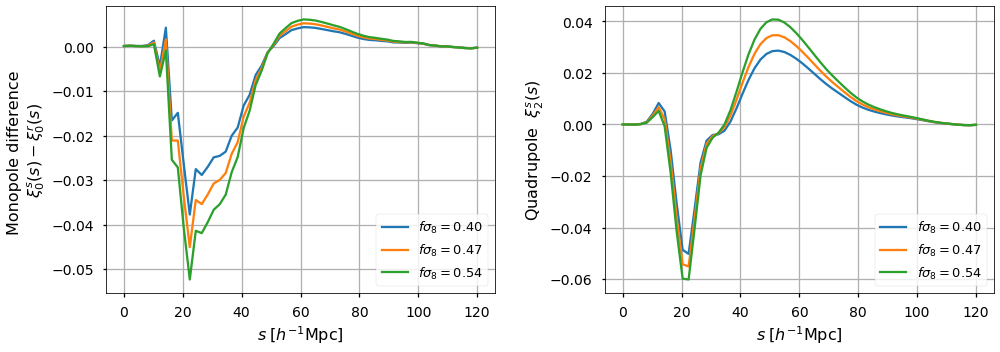

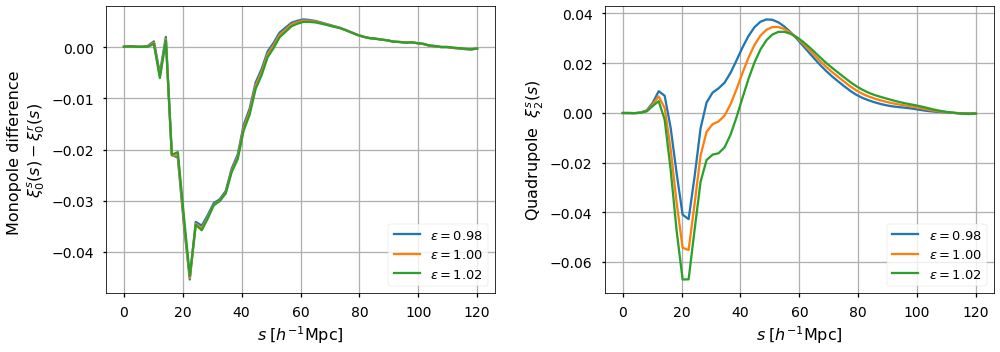

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
params1 = {'fsigma8': 0.40, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 1.0, 'label': r'$f\sigma_8=0.40$'}
params2 = {'fsigma8': 0.47, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 1.0, 'label': r'$f\sigma_8=0.47$'}
params3 = {'fsigma8': 0.54, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 1.0, 'label': r'$f\sigma_8=0.54$'}
s = np.linspace(0.01, 120, 60)
ccf.plot_model_multipoles(params1, params2, params3, s=s, ax=ax1, ell=0, diff=True, **{'xlabel': r'$s\;[h^{-1}\mathrm{Mpc}]$', 'ylabel': 'Monopole difference \n' + r'$\xi^s_0(s)-\xi^r_0(s)$'})
ccf.plot_model_multipoles(params1, params2, params3, s=s, ax=ax2, ell=2, **{'xlabel': r'$s\;[h^{-1}\mathrm{Mpc}]$', 'ylabel': r'Quadrupole  $\xi^s_2(s)$'})
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
for ax in [ax1, ax2]:
    ax.xaxis.get_label().set_fontsize(16)
    ax.yaxis.get_label().set_fontsize(16)
    ax.tick_params(labelsize=14)
    ax.grid()
plt.tight_layout(w_pad=3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
params1 = {'fsigma8': 0.47, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 0.98, 'label': r'$\epsilon=0.98$'}
params2 = {'fsigma8': 0.47, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 1.0, 'label': r'$\epsilon=1.00$'}
params3 = {'fsigma8': 0.47, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 1.02, 'label': r'$\epsilon=1.02$'}
s = np.linspace(0.01, 120, 60)
ccf.plot_model_multipoles(params1, params2, params3, s=s, ax=ax1, ell=0, diff=True, **{'xlabel': r'$s\;[h^{-1}\mathrm{Mpc}]$', 'ylabel': 'Monopole difference \n' + r'$\xi^s_0(s)-\xi^r_0(s)$'})
ccf.plot_model_multipoles(params1, params2, params3, s=s, ax=ax2, ell=2, **{'xlabel': r'$s\;[h^{-1}\mathrm{Mpc}]$', 'ylabel': r'Quadrupole  $\xi^s_2(s)$'})
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
for ax in [ax1, ax2]:
    ax.xaxis.get_label().set_fontsize(16)
    ax.yaxis.get_label().set_fontsize(16)
    ax.tick_params(labelsize=14)
    ax.grid()
plt.tight_layout(w_pad=3)

Note that the left-panel plots now show the *difference* between the model multipole and the real-space input.

We can also compute and plot the 2D CCF $\xi^s(s_\perp,s_{||})$ instead:

[-100.  -50.    0.   50.  100.]


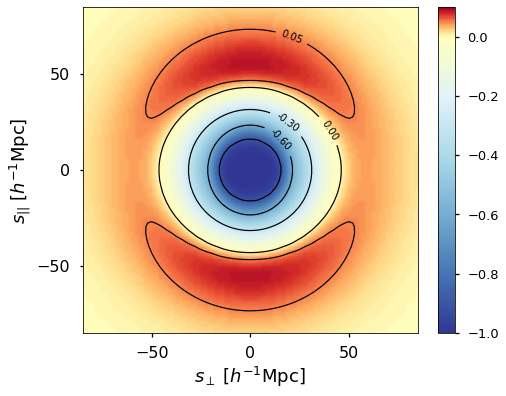

In [9]:
params = {'fsigma8': 0.47, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 1.0}
xi2d = ccf.theory_xi_2D(params)
s = np.linspace(0, 85)
contours = [-0.9, -0.6, -0.3, 0, 0.05]
plottools.plot_2D_ccf(xi2d, s, vmin=-1, vmax=0.1, contours=contours, contour_colors='k', clabel=True, axis_label='s')

# 2. Data fitting with the `CCFFit` class

All data fitting operations and posterior analyses are enabled by the `CCFFit` class, which inherits model calculations from `CCFModel`. Additional information required to initialise a `CCFFit` instance (including the path to the file containing the observed redshift-space data vector, the covariance matrix, and various fitting options) is provided via another dictionary `data`. An example of this for the BOSS DR12 data is also provided in the YAML file:

In [10]:
from victor import CCFFit

top_level_dir = os.path.dirname(os.getcwd()) # to step back up from the current notebook directory

with open(os.path.join(top_level_dir, 'config/boss_config.yaml')) as f:
    info = yaml.full_load(f)
    model = info['model']
    data = info['data']
    
# as before, adjust for the working directory
model['dir'] = top_level_dir
data['dir'] = top_level_dir

ccf = CCFFit(model, data)

print(f'Data fitting options used: {data}')

Data fitting options used: {'redshift_space_ccf': {'reconstruction': True, 'data_file': 'data/BOSS_DR12_CMASS_data/CMASS_zobovVoids_reconRs10_0.43z0.7_medianRvcut_data.hdf5', 'format': 'multipoles', 'ccf_keys': ['s', 'monopole', 'quadrupole'], 'beta_key': None}, 'covariance_matrix': {'data_file': 'data/BOSS_DR12_CMASS_data/CMASS_zobovVoids_reconRs10_0.43z0.7_medianRvcut_variable_D_covariance.hdf5', 'cov_key': 'covmat', 'fixed_beta': False, 'beta_key': 'beta'}, 'beta_interpolation': 'datavector', 'likelihood': {'form': 'sellentin', 'nmocks': 1000, 'nparams': 4}, 'dir': '/Users/seshadri/libraries/void-galaxy-cosmo-fitter'}


For now, all comparisons between models and data in `CCFFit` have to be performed via compression to multipole moments of the redshift-space CCF. Since the redshift-space CCF data provided here has monopole and quadrupole moments included, fits will be performed using these two multipole moments (and the covariance matrix will be required to have the appropriate shape or the code with throw an error). Hexadecapole moments can be accommodated too if you have measured these in your data.

## Evaluating the likelihood at a point in parameter space

The log-likelihood and chi-squared values can be accessed via the `log_likelihood` method. Note that because various options can be implemented to correct the likelihood for uncertainties in the covariance matrix estimation from mocks (using the Hartlap, or Sellentin & Heavens, or Percival et al approaches), the naive expectation that $\mathcal{L}\propto\exp(-\chi^2/2)$ for a Gaussian likelihood need not hold. In addition, if the covariance matrix provided has a dependence on the value of the reconstruction parameter $\beta$ (as in this example case), this is accounted for in a normalisation factor used to calculate the likelihood. Any special options for evaluation can be passed as kwargs to override the defaults set during initialisation.

In [11]:
params = {'fsigma8': 0.47, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 1.0}
lnlkl, chi2 = ccf.log_likelihood(params)
print(f'At {params} using the {model["rsd_model"]} model,\n\t chi2 = {chi2:.2f} and log-likelihood = {lnlkl:.2f}')

lnlkl, chi2 = ccf.log_likelihood(params, **{'rsd_model': 'dispersion'})
print(f'At {params} using the dispersion model,\n\t chi2 = {chi2:.2f} and log-likelihood = {lnlkl:.2f}')

lnlkl, chi2 = ccf.log_likelihood(params, **{'rsd_model': 'kaiser'})
print(f'At {params} using the Kaiser model,\n\t chi2 = {chi2:.2f} and log-likelihood = {lnlkl:.2f}')

lnlkl, chi2 = ccf.log_likelihood(params, **{'assume_isotropic': False})
print(f'At {params} using the {model["rsd_model"]} model, but accounting for anisotropy of realspace input,\n\t chi2 = {chi2:.2f} and log-likelihood = {lnlkl:.2f}')

lnlkl, chi2 = ccf.log_likelihood(params, **{'beta_interpolation': 'likelihood'})
print(f'At {params} using the {model["rsd_model"]} model, but performing beta interpolation at likelihood (not datavector) level,\n\t chi2 = {chi2:.2f} and log-likelihood = {lnlkl:.2f}')



At {'fsigma8': 0.47, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 1.0} using the streaming model,
	 chi2 = 65.01 and log-likelihood = 284.76
At {'fsigma8': 0.47, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 1.0} using the dispersion model,
	 chi2 = 63.67 and log-likelihood = 285.39
At {'fsigma8': 0.47, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 1.0} using the Kaiser model,
	 chi2 = 103.90 and log-likelihood = 266.81
At {'fsigma8': 0.47, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 1.0} using the streaming model, but accounting for anisotropy of realspace input,
	 chi2 = 64.39 and log-likelihood = 285.06
At {'fsigma8': 0.47, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 1.0} using the streaming model, but performing beta interpolation at likelihood (not datavector) level,
	 chi2 = 64.80 and log-likelihood = 285.30


To see the different model results compared to the data:

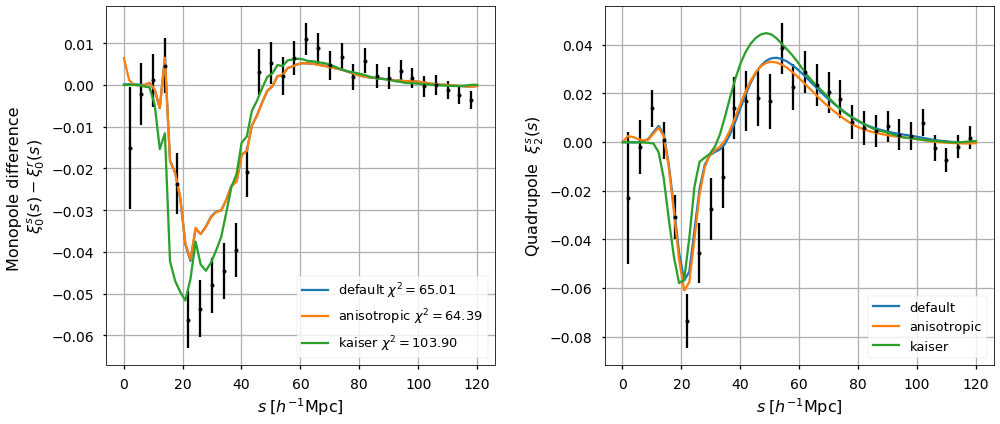

In [12]:
params1 = {'fsigma8': 0.47, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 1, 'label': 'default'}
params2 = {'fsigma8': 0.47, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 1, 'label': 'anisotropic', 'options': {'assume_isotropic': False}}
params3 = {'fsigma8': 0.47, 'beta': 0.37, 'sigma_v': 380, 'epsilon': 1, 'label': 'kaiser', 'options': {'rsd_model': 'kaiser'}}

s = np.linspace(0.1, 120, 70)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ccf.plot_multipole_comparison(params1, params2, params3, s=s, ax=ax1, ell=0, diff=True, **{'chi2': True, 'ylabel': 'Monopole difference \n' + r'$\xi^s_0(s)-\xi^r_0(s)$'})
ax1.legend(loc='lower right')
ccf.plot_multipole_comparison(params1, params2, params3, s=s, ax=ax2, ell=2, **{'ylabel': r'Quadrupole  $\xi^s_2(s)$'})
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
for ax in [ax1, ax2]:
    ax.xaxis.get_label().set_fontsize(16)
    ax.yaxis.get_label().set_fontsize(16)
    ax.tick_params(labelsize=14)
    ax.grid()
plt.tight_layout(w_pad=3)

## MCMC sampling with `cobaya`

This section assumes you have installed `victor` with the extra packages for MCMC, or you have `cobaya` pre-installed.

To perform MCMC sampling of the posterior for a given model and data, you can run chains using `cobaya` and the interface with `victor`. To do this you first need to prepare an input YAML file for `cobaya` to parse. This will contain a `likelihood` block specifying the likelihood to use and associated options (including the `model` and `data` dictionaries we have been using above) as well as blocks providing information for `cobaya` on the sampler to use, the parameters to sample over and their priors, and the output directory for chains to be stored. An example input file set up to run chains on the BOSS DR12 data is provided in `config/boss_cobaya_config.yaml` which should help explain the format. For more information, refer to the [Cobaya documentation](https://cobaya.readthedocs.io/en/latest/index.html).

### Running chains from the terminal

From the package directory, execute

`cobaya-run config/boss_cobaya_config.yaml`

After a few seconds, a folder called `chains/` will be created containing files named `test.*`, including `test.1.txt` which while contain the MCMC sample.

The above command uses a single core and produces a single chain but if you have `mpi4py` installed (**highly** recommended but not automatically bundled with this package), you can run multiple chains in parallel for faster convergence by

`mpirun -n [n_processes] cobaya-run config/boss_cobaya_config.yaml`

When running on some HPC clusters, you may need to replace `mpirun` with `srun`.

### Running chains from a Python interpreter

To run chains from a Jupyter notebook or other Python interpreter, you can do the following:

In [13]:
# from cobaya.yaml import yaml_load_file
# from cobaya.run import run

# # optionally load info from the example yaml file
# info = yaml_load_file("../config/boss_cobaya_config.yaml")

# # manipulate the loaded info according to your needs – e.g. if your working directory is not 
# # the package directory then you may need to update file paths to those defined in the yaml
# # as in the earlier examples in this notebook

# updated_info, sampler = run(info)


The `.txt` chain files produced by `cobaya` should have self-explanatory headers and you can read and analyse them with `GetDist` (included here as an optional extra dependency) or your favourite analysis software.